In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

### Métodos de utilidad

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [95]:
def graficar_varianza(pca, width=8, dpi=100):
    
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", title="% Varianza explicada", ylim=(0.0, 1.0)
    )
    
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", title="% Varianza Acumulada", ylim=(0.0, 1.0)
    )
    
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

### Lectura

In [78]:
df = pd.read_csv("datos/autos.csv")

In [80]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]


In [84]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

<AxesSubplot:xlabel='engine_size', ylabel='Count'>

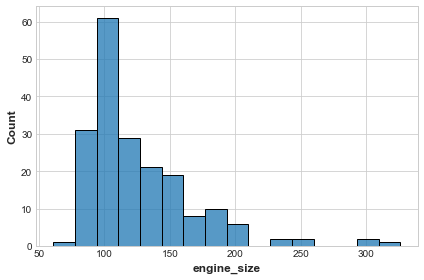

In [86]:
sns.histplot(X.engine_size)

<AxesSubplot:xlabel='engine_size', ylabel='Count'>

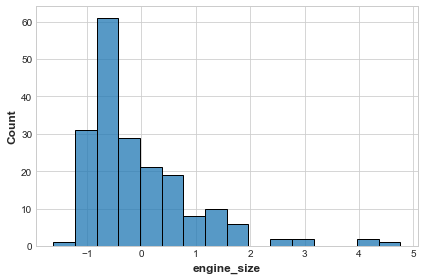

In [87]:
sns.histplot(X_scaled.engine_size)

<AxesSubplot:>

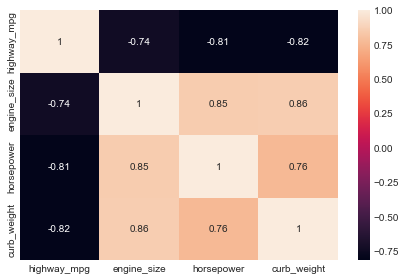

In [88]:
sns.heatmap(X.corr(),annot=True)

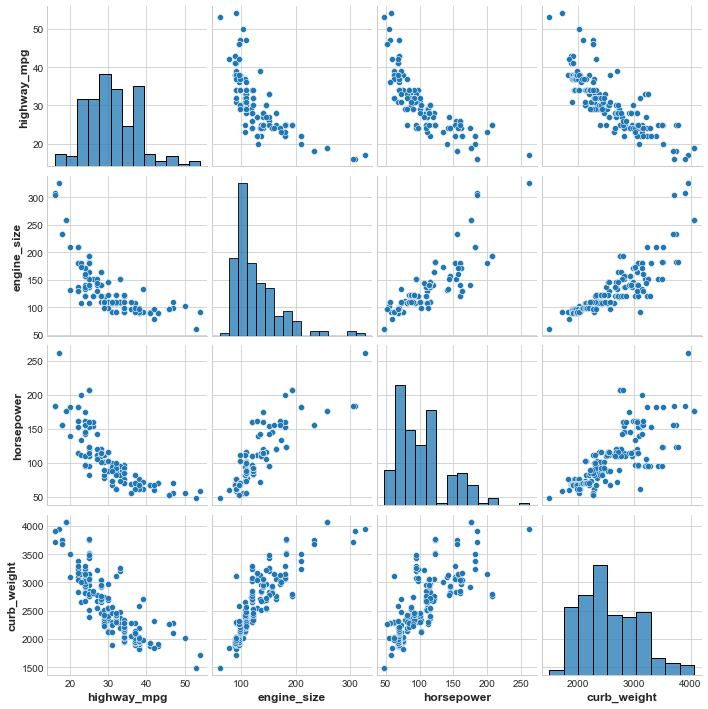

In [89]:
sns.pairplot(X)

### PCA

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [97]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [98]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names,  
    index=X.columns, 
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


<AxesSubplot:>

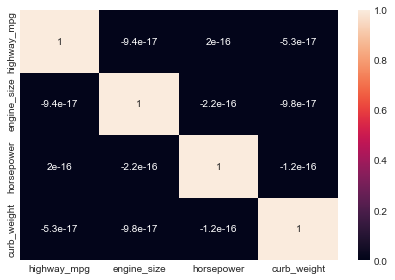

In [94]:
sns.heatmap(pd.DataFrame(pca.fit_transform(X),columns=X.columns).corr(),annot=True)

array([<AxesSubplot:title={'center':'% Varianza explicada'}, xlabel='Componente'>,
       <AxesSubplot:title={'center':'% Varianza Acumulada'}, xlabel='Componente'>],
      dtype=object)

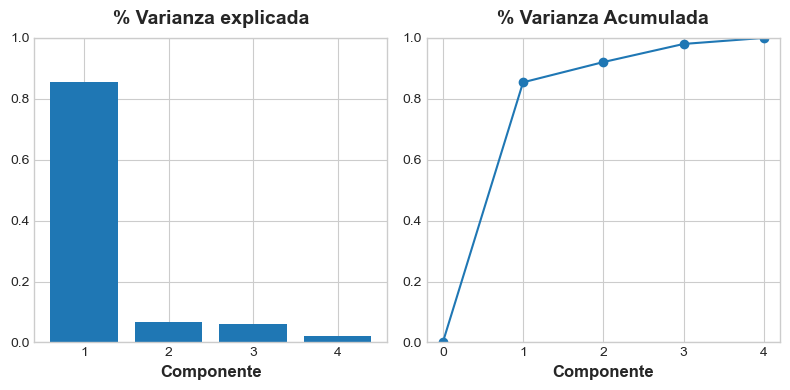

In [99]:
graficar_varianza(pca)

#### Usando Pipelines

In [ ]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)


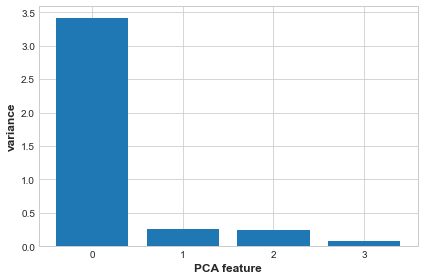

In [100]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [106]:
ComponentesPrincipales = pd.DataFrame(pipeline.fit_transform(X)).iloc[:,:2]

### Clustering

In [107]:
from sklearn.cluster import KMeans

In [108]:
modelitos_clustering = [
    KMeans(n_clusters=n, random_state=42) for n in range(2,20)]

In [109]:
inercia = [model.fit(X_scaled).inertia_ for model in modelitos_clustering]

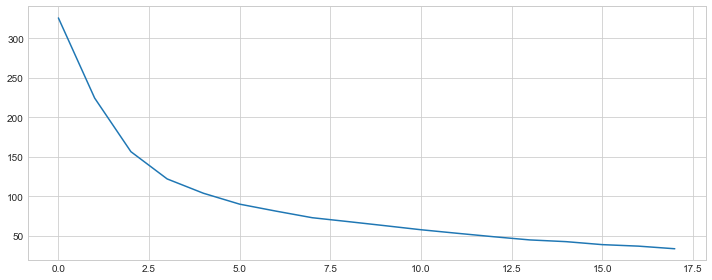

In [110]:
plt.figure(figsize=(10,4))
plt.plot(inercia)
plt.show()

In [113]:
mod_clust = modelitos_clustering[1]

In [116]:
(
    X
    .assign(
        segmentos = mod_clust.fit_predict(X_scaled)
        )
    .groupby('segmentos')
    .agg("mean")
 
)

,highway_mpg,engine_size,horsepower,curb_weight
segmentos,,,,
0,26.746269,134.746269,117.791045,2826.686567
1,35.858586,101.787879,75.949495,2159.898990
2,22.222222,208.259259,168.925926,3376.037037


<AxesSubplot:xlabel='horsepower', ylabel='Count'>

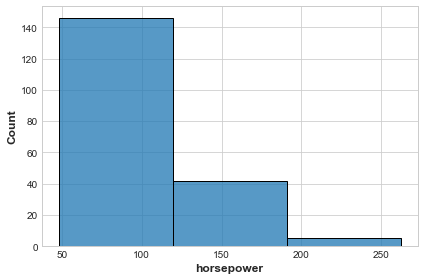

In [118]:
sns.histplot(X.horsepower,bins=3)

In [70]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [120]:
mergings = linkage(X, method='complete')

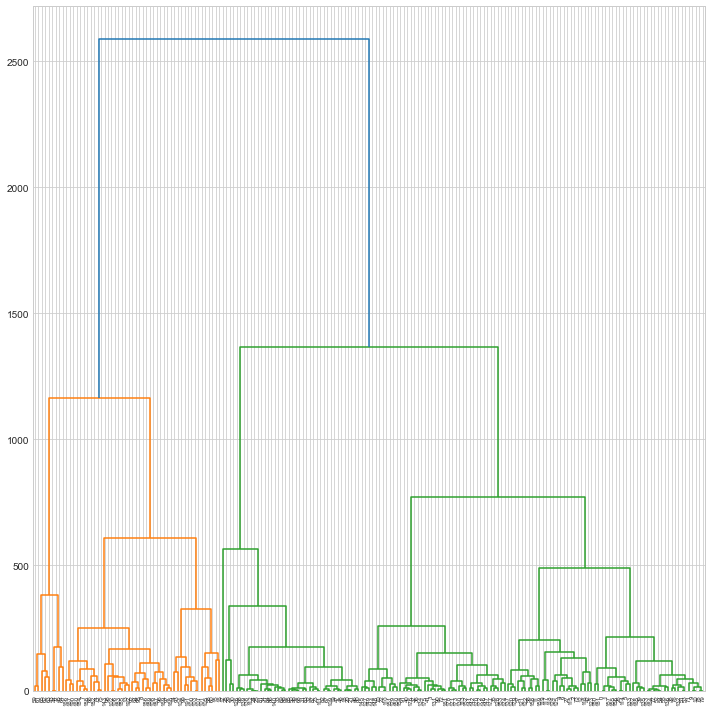

In [122]:
plt.figure(figsize=(10,10))
dendrogram(mergings,
           #labels=X.columns,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()
